<a href="https://colab.research.google.com/github/ferdinand1810/Metodos_Numericos_Aplicados_Ingenieria_UTEC/blob/main/Transporte_Microplastico_RK4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

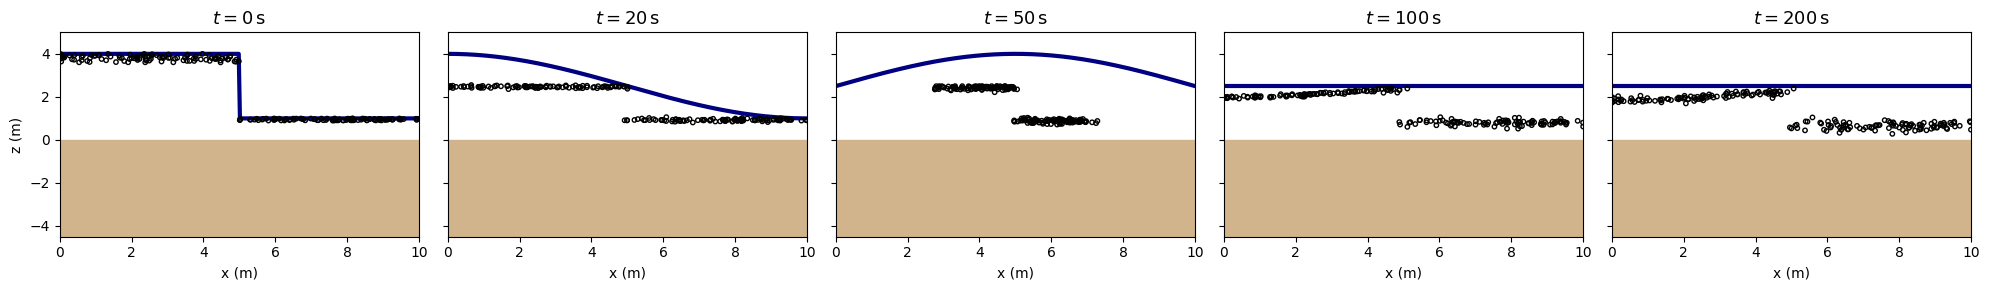

In [22]:
# MODELO LAGRANGIANO DEL TRANSPORTE DE MICROPLASTICO EN CANALES FLUVIALES
# RESUELTO CON EL METODO RUNGE-KUTTA DE CUARTO ORDEN
           ###### Luis F. Castro, Master Student at UTEC ########
import numpy as np
import matplotlib.pyplot as plt

# Parámetros físicos
g = 9.81
rho_w = 1000
rho_p = 900
nu_w = 1e-6

# Geometría y partículas
L, B = 10.0, 4.0
n_particles = 200
D = 2e-3
R = D / 2

# Tiempo
dt = 0.1
T = 200.0
N = int(T / dt) + 1  # Incluye snapshot t=200

# Función de la superficie de agua
def water_surface(x, t):
    if t == 0:
        return np.where(x < L / 2, 4, 1)
    elif t == 20:
        return 2.5 + 1.5 * np.cos(np.pi * x / L)
    elif t == 50:
        return 2.5 + 1.5 * np.sin(np.pi * x / L)
    else:
        return 2.5 + 0.5 * np.sin(2 * np.pi * t / 100) * np.cos(np.pi * x / L)

# Campo de velocidades 2D
def velocity_field(x, y, t):
    u = 0.5 * np.sin(2 * np.pi * t / 20) * np.cos(np.pi * x / L)
    v = 0.2 * np.sin(2 * np.pi * t / 30) * np.cos(np.pi * y / B)
    return u, v

# Velocidad de hundimiento (constante)
def sinking_velocity_sphere(D):
    d_star = D * ((g * (rho_p - rho_w)) / (rho_w * nu_w**2))**(1/3)
    return -(nu_w / D) * d_star * (0.093 * d_star**1.25 + 3.81)**(-1)

# Caminata aleatoria
def random_walk_term(scale=0.005):
    return np.random.normal(0, scale)

# RK4 para una componente
def rk4_component(f, pos, t, dt):
    k1 = dt * f(pos, t) + random_walk_term()
    k2 = dt * f(pos + 0.5 * k1, t + 0.5 * dt) + random_walk_term()
    k3 = dt * f(pos + 0.5 * k2, t + 0.5 * dt) + random_walk_term()
    k4 = dt * f(pos + k3, t + dt) + random_walk_term()
    return np.real((k1 + 2*k2 + 2*k3 + k4) / 6)

# Inicializar partículas
particles = np.zeros((n_particles, 3, N))
particles[:, 0, 0] = np.random.uniform(0, L, n_particles)  # x
particles[:, 1, 0] = np.random.uniform(0, B, n_particles)  # y
particles[:, 2, 0] = np.array([
    np.random.uniform(0.9, 1.0) * water_surface(xi, 0) for xi in particles[:, 0, 0]
])  # z

# Constante de hundimiento
ws = sinking_velocity_sphere(D)

# Simulación
for n in range(N - 1):
    t = n * dt
    for i in range(n_particles):
        x0, y0, z0 = particles[i, :, n]

        u_func = lambda x, t: velocity_field(x, y0, t)[0]
        v_func = lambda y, t: velocity_field(x0, y, t)[1]
        w_func = lambda z, t: ws  # constante

        dx = rk4_component(u_func, x0, t, dt)
        dy = rk4_component(v_func, y0, t, dt)
        dz = rk4_component(w_func, z0, t, dt)

        x_new = np.clip(x0 + dx, 0, L)
        y_new = np.clip(y0 + dy, 0, B)
        z_surf = water_surface(x_new, t + dt)
        z_new = np.clip(z0 + dz, -4.0, z_surf)

        particles[i, :, n + 1] = [x_new, y_new, z_new]

# Graficar snapshots extendidos
fig, axes = plt.subplots(1, 5, figsize=(20, 3), sharey=True)
snapshots = [0, 20, 50, 100, 200]
titles = [rf"$t={t}\,\mathrm{{s}}$" for t in snapshots]

for idx, (t_snap, ax) in enumerate(zip(snapshots, axes)):
    n = int(t_snap / dt)
    x = particles[:, 0, n]
    z = particles[:, 2, n]

    ax.fill_between([0, L], -4.5, 0, color='tan', zorder=0)
    x_surf = np.linspace(0, L, 300)
    h_surf = water_surface(x_surf, t_snap)
    ax.plot(x_surf, h_surf, color='navy', linewidth=3, zorder=1)
    ax.scatter(x, z, s=10, facecolors='none', edgecolors='black', zorder=2)

    ax.set_xlim(0, L)
    ax.set_ylim(-4.5, 5)
    ax.set_title(titles[idx], fontsize=13)
    ax.set_xlabel("x (m)")

axes[0].set_ylabel("z (m)")
plt.tight_layout()
plt.show()


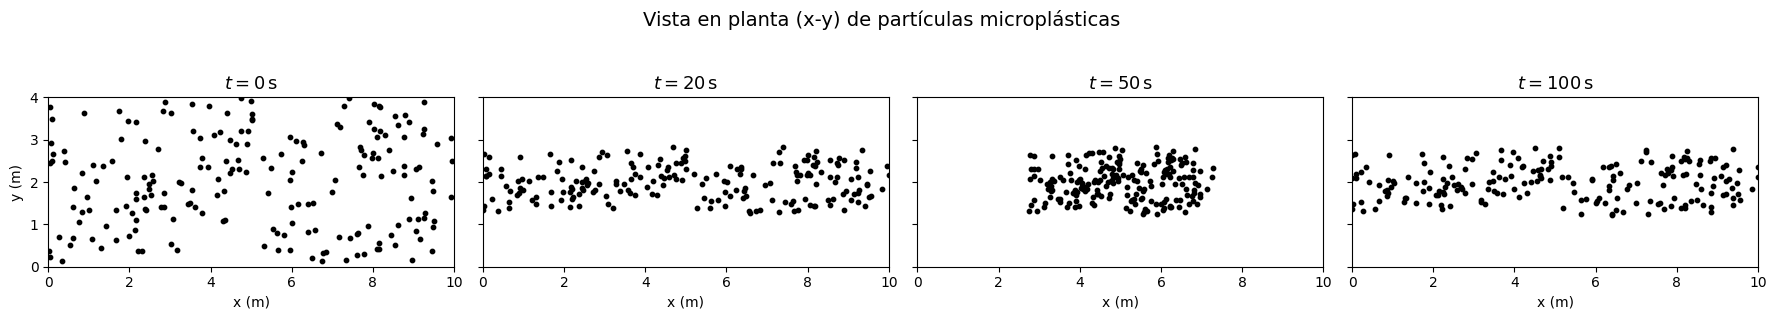

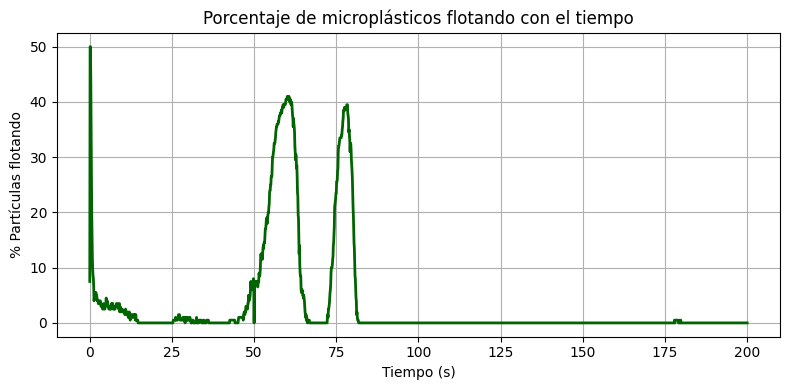

In [23]:
import matplotlib.pyplot as plt

# --- VISTA EN PLANTA (x-y) ---
fig, axes = plt.subplots(1, 4, figsize=(18, 3), sharey=True)
titles = [rf"$t={t}\,\mathrm{{s}}$" for t in snapshots]

for idx, (t_snap, ax) in enumerate(zip(snapshots, axes)):
    n = int(t_snap / dt)
    x = particles[:, 0, n]
    y = particles[:, 1, n]

    ax.scatter(x, y, s=10, c='black', zorder=2)
    ax.set_xlim(0, L)
    ax.set_ylim(0, B)
    ax.set_title(titles[idx], fontsize=13)
    ax.set_xlabel("x (m)")

axes[0].set_ylabel("y (m)")
plt.suptitle("Vista en planta (x-y) de partículas microplásticas", y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

# --- PORCENTAJE DE PARTÍCULAS FLOTANDO VS TIEMPO ---
percent_floating = []
times = []

for n in range(N):
    t = n * dt
    x = particles[:, 0, n]
    z = particles[:, 2, n]
    surface_heights = water_surface(x, t)
    floating = z >= surface_heights - 0.01  # margen tolerante de 1 cm
    percent = 100 * np.sum(floating) / n_particles
    percent_floating.append(percent)
    times.append(t)

# Graficar
plt.figure(figsize=(8, 4))
plt.plot(times, percent_floating, color='darkgreen', lw=2)
plt.xlabel("Tiempo (s)")
plt.ylabel("% Partículas flotando")
plt.title("Porcentaje de microplásticos flotando con el tiempo")
plt.grid(True)
plt.tight_layout()
plt.show()